# Project #6

Due Monday, Nov 5nd, 5pm.

1. You may implement the solution to this problem in any way that you wish.  You may use any iterative clustering type algorithm, which clusters based on the Manhattan ($L_1$) distance metric, which is less sensitive to outliers.  Assume that the $D$ features are real valued quantities, i.e., $x\in\mathbb{R}^D$  represents a sample.  The Manhattan distance between two samples $x$ and $y$ can be computed as
\begin{align}
d(x,y) = \sum_{i=1}^{D} |x_i - y_i|.
\end{align}
Test your algorithm on the toy data sets used in this example:
http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py, (i.e., your implemented algorithm with the Manhattan distance should add a column to the row of images). Commenting on what you .
<br>

### Problem 1

In [1]:
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pylab as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

manhat = cluster.DBSCAN(eps = 0.3, min_samples = 10, metric = 'cityblock')
manhata = cluster.AgglomerativeClustering(affinity='manhattan',linkage='average')
manhat2 = cluster.DBSCAN(eps = 0.2, min_samples = 5, metric = 'cityblock')
#y_mhat = manhat.fit_predict(X)
#y_mhata = manhata.fit_predict(X)
#y_mhat2 = manhat2.fit_predict(X)

NameError: name 'X' is not defined

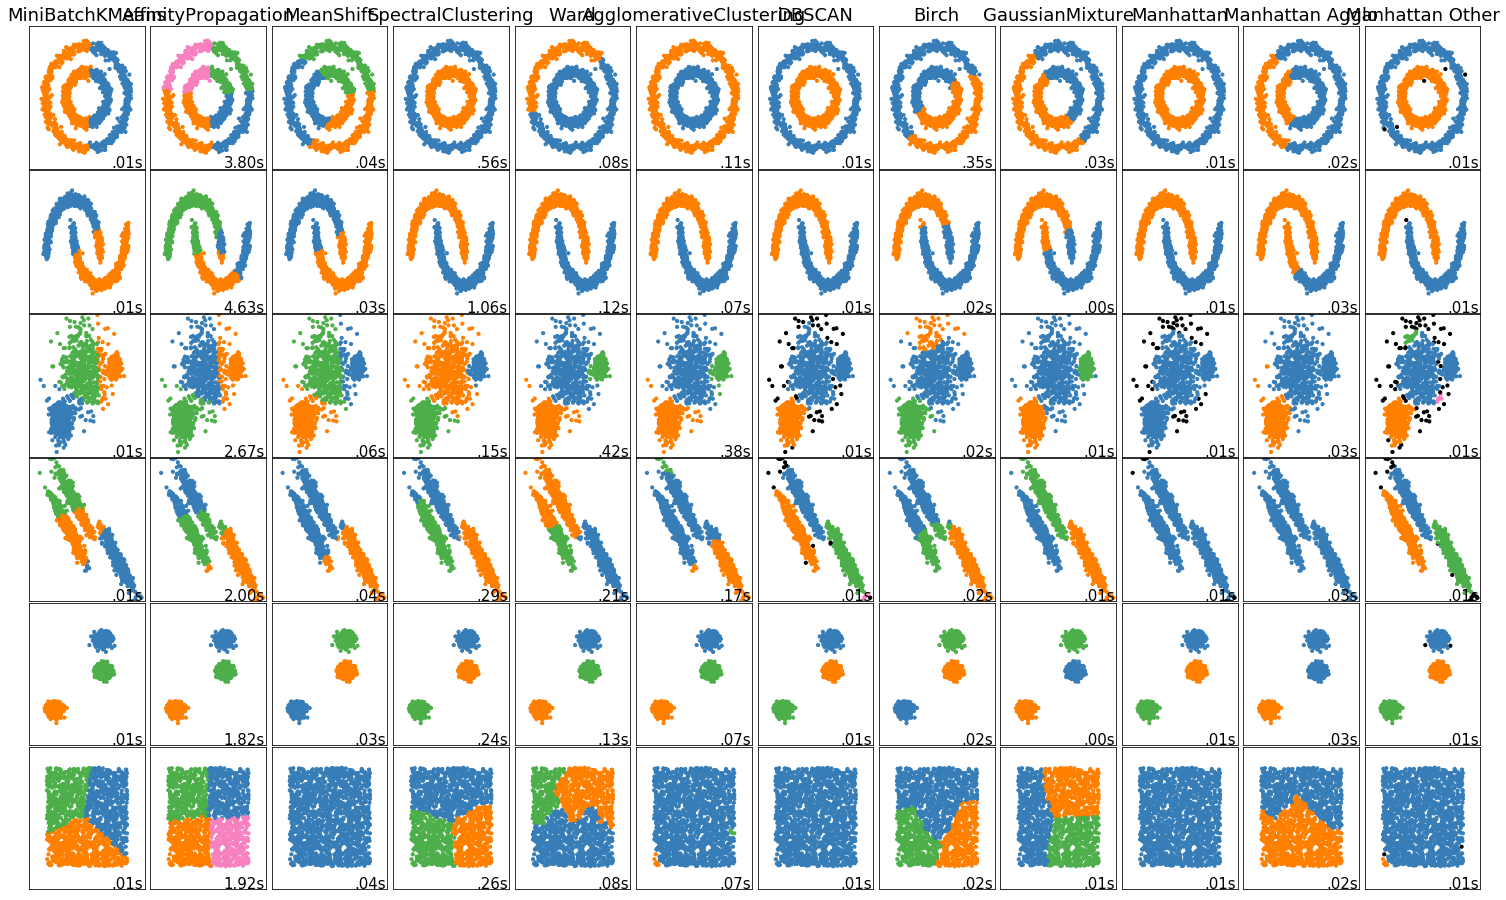

In [2]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    manhat = cluster.DBSCAN(eps = 0.3, min_samples = 10, metric = 'cityblock')
    manhata = cluster.AgglomerativeClustering(affinity='manhattan',linkage='average')
    manhat2 = cluster.DBSCAN(eps = 0.2, min_samples = 5, metric = 'cityblock')
    
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('Manhattan',manhat),
        ('Manhattan Agglo',manhata),  
        ('Manhattan Other',manhat2)
        
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Upon implementing my algorithm into the toy data set I noticed the following things:<br>
### 1] Comparing Column 10 with others <br>
Using the DBSCAN version of the manhattan algorithm had much the same results as DBSCAN using euclidean. For concentric circles, half moons, balls, and no structure datasets, both algorithms returned the same results. Blobs returned similar results however under the euclidean DBSCAN there was enough variation in the data to warrant a second cluster. Lines in the DBSCAN manhattan distance were all in a single cluster with a few outliers whereas DBSCAN euclidean returned 3 distinct clusters with more outliers.<br>
### 2] Comparing Column 11 with others <br>
Using the Agglomerative clustering version for manhattan distance resulted in far more variation.  For example in the concentric circles and half moons both figures had clusters which related parts of different shapes together.  Blobs, and lines in the Agglomerative clustering resulted with no outliers.  Additionally Balls and no structure datasets returned only 2 clusters each. <br>
### 3] Comparing Column 12 with others <br>
I also tried played around with the eps values and noticed that upon using 0.2 and 5 as eps and neighbor values respecively: Concentric circles showed outliers while having consistent clusters with DBSCAN euclidean and manhattan.  One outlier exists for the half moon shapes where otherwise there was none. The blobs contain multiple datasets as well as many outliers.  Lines and balls have the same clusters in both DBSCAN euclidean and manhattan with adifferences in a few outliers. Lastly with the exception of a few outliers the no structure dataset for Manhattan Other has similar clustering patterns as the Agglomerative clustering pattern in column 6.   

# Problem 2
2. The following tutorial shows you how to use Keras (and tensorflow) to perform supervised learning on the MINST fashion images.  https://www.tensorflow.org/tutorials/keras/basic_classification
    1. work through the tutorial. Explain in your own words what is auto-encoding.
    2. apply unsupervised learning to an appropriate **subset** data set (i.e. ignore the labels) to see if you can cluster the different types of clothing in this data set.

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.10.1


In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
len(train_labels)

60000

In [8]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
len(test_labels)

10000

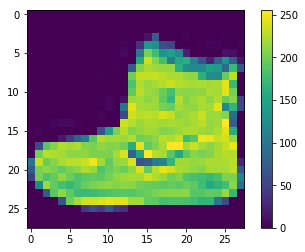

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0

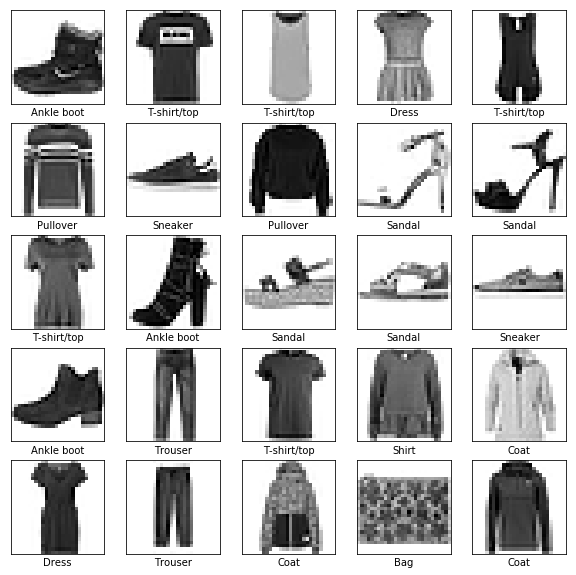

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [15]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.4935 - acc: 0.8259
Epoch 2/5
60000/60000 [==============================] - 2s 28us/step - loss: 0.3692 - acc: 0.8671
Epoch 3/5
60000/60000 [==============================] - 2s 28us/step - loss: 0.3335 - acc: 0.8779
Epoch 4/5
60000/60000 [==============================] - 2s 29us/step - loss: 0.3098 - acc: 0.8854
Epoch 5/5
60000/60000 [==============================] - 2s 28us/step - loss: 0.2927 - acc: 0.8922


In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 16us/step
('Test accuracy:', 0.8796)


In [18]:
predictions = model.predict(test_images)

In [19]:
predictions[0]

array([9.0271220e-05, 7.9568586e-08, 1.2632817e-06, 3.2182132e-07,
       2.2051563e-05, 1.1469823e-03, 5.4776759e-05, 2.8081894e-02,
       1.8441392e-04, 9.7041792e-01], dtype=float32)

In [20]:
np.argmax(predictions[0])

9

In [21]:
test_labels[0]

9

In [22]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

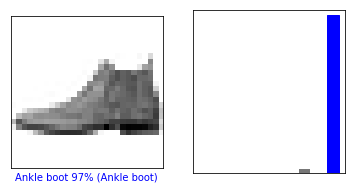

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

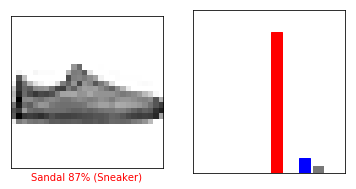

In [24]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

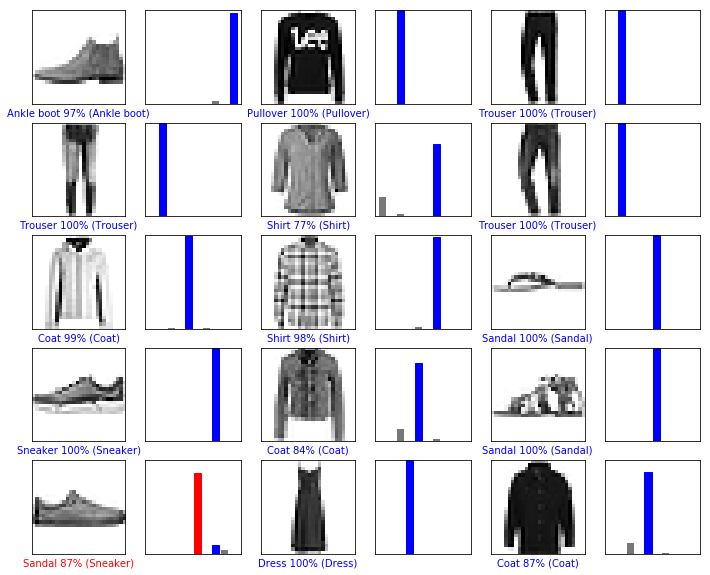

In [25]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [26]:
img = test_images[0]

print(img.shape)

(28, 28)


In [27]:
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [28]:
predictions_single = model.predict(img)

print(predictions_single)

[[9.0271220e-05 7.9568437e-08 1.2632781e-06 3.2182007e-07 2.2051563e-05
  1.1469829e-03 5.4776810e-05 2.8081901e-02 1.8441392e-04 9.7041792e-01]]


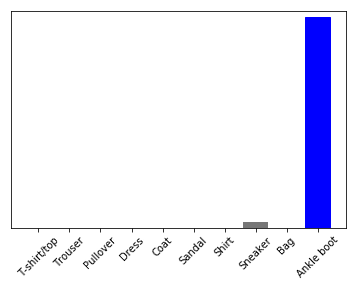

In [29]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [31]:
np.argmax(predictions_single[0])

9

### My understanding of Auto-encoding
Auto-encoding is a type of neural network which uses dimension reduction to translate original data into data which closely represents the original data. Doing this auto-encoders learn representations of data which make clustering and other data analysis methods easier to work with and to understand.  

### Part 2
apply unsupervised learning to an appropriate subset data set (i.e. ignore the labels) to see if you can cluster the different types of clothing in this data set.

In [64]:
train_images = np.array(train_images[1:5000])
test_images = np.array(test_images[1:5000])

(4997, 28, 28)

In [37]:
train_images.shape
for i in range(0,4998):
    np.array(train_images[i]).reshape(28,28)

In [66]:
from sklearn import cluster
from sklearn.cluster import KMeans

K=10 # Assuming to be 9 clusters!

km = KMeans(n_clusters=K,init="random", n_init=10,max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(train_images[:,1,:])

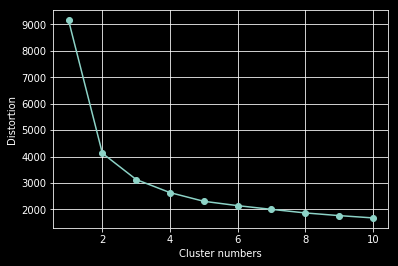

In [67]:
distortions = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init="k-means++", n_init=10,max_iter=100, random_state=0)
    km.fit(train_images[:,1,:])
    distortions.append(km.inertia_)

plt.plot(range(1,11),distortions, marker ='o')
plt.xlabel('Cluster numbers')
plt.ylabel('Distortion')
plt.grid()
plt.show()

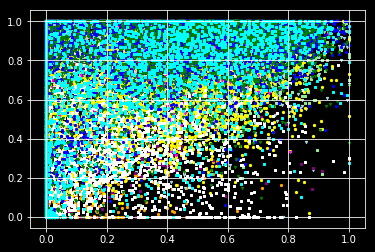

In [57]:
# Use scatter plot matrix to visualize the samples and the centroids
plt.scatter(train_images[y_km ==0,0],train_images[y_km ==0,1],s=5,c='lightgreen',marker="s",label='cluster 1')
plt.scatter(train_images[y_km ==1,0],train_images[y_km ==1,1],s=5,c='orange',marker="o",label='cluster 2')
plt.scatter(train_images[y_km ==2,0],train_images[y_km ==2,1],s=5,c='lightblue',marker="v",label='cluster 3')
plt.scatter(train_images[y_km ==3,0],train_images[y_km ==3,1],s=5,c='purple',marker="s",label='cluster 4')
plt.scatter(train_images[y_km ==4,0],train_images[y_km ==4,1],s=5,c='yellow',marker="o",label='cluster 5')
plt.scatter(train_images[y_km ==5,0],train_images[y_km ==5,1],s=5,c='magenta',marker="v",label='cluster 6')
plt.scatter(train_images[y_km ==6,0],train_images[y_km ==6,1],s=5,c='white',marker="s",label='cluster 7')
plt.scatter(train_images[y_km ==7,0],train_images[y_km ==7,1],s=5,c='blue',marker="o",label='cluster 8')
plt.scatter(train_images[y_km ==8,0],train_images[y_km ==8,1],s=5,c='green',marker="v",label='cluster 9')
plt.scatter(train_images[y_km ==9,0],train_images[y_km ==9,1],s=5,c='cyan',marker="s",label='cluster 10')
#plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=250,marker="*",c="red",label="centroids??")
#'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#plt.legend()
plt.grid()
plt.show()
plt.figure.figsize=(100,100)